In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ddeint import ddeint

class IkedaEquation:
    """
    Differential Equation with the nonlinear delay feedback
    (from the paper above)
    
    Parameters
        beta = weight of the nonlinear feedback
        tau = response time
        delay = magnitude of the delay
    """
    def __init__(self, beta, tau, delay, ic):
        self.beta = beta
        self.tau = tau
        self.delay = delay
        self.ic = ic
        
    def __call__(self, t, y):
        return self.rhs(t, y)
    
    def rhs(self, t, y):
        """
        RHS of the ikeda map delay differential equation
        
        From the paper, Ikeda-based nonlinear delayed dynamics for application to secure optical transmission systems using chaos, L. Larger, C.R. Physique 5 (2004)
        
        """
        return (self.beta/self.tau) * ((np.sin(y(t - self.delay)))**2) - y(t)/self.tau
    
    def values_before_zero(self, t):
        """
        define the history function before zero
        
        """
        return self.ic
    
    def solve(self, t_min, t_max, nt):
        """
        Solve the logistic equation using the ddeint solver based on scipy
        
        ###
        Currently not implemented due to a mysterious error. Thus calling the ddeint from the ddeint package directly
        ###
        """
        tpts = np.linspace(t_min, t_max, nt)
        sol = ddeint(self.rhs, self.values_before_zero, tpts)
        return tpts, sol
    
            
    
class LogisticEquation:
    """
    Logistic equation, which is dy/dx = (b-cx)x
    (from Feliciano's lecture note)
    
    Parameters
        b = weight of the nonlinear feedback
        c = response time
        
    """
    def __init__(self, b, c):
        self.b = b
        self.c = c
        
    def __call__(self, t, X):
        return self.rhs(t, X)
    
    def rhs(self, t, X):
        """
        RHS of the logistic equation in a differential equation form
        
        """
        y = X
        ydot = (self.b-self.c*y)*y
        return np.array([ydot])
    
    def solve(self, ic, t_min, t_max, nt, **kwargs):
        """
        Solve the logistic equation using the odeint solver in scipy
        
        Returns:
            array : solution for an ordinary differential equation
        
        """
        tpts = np.linspace(t_min, t_max, nt)
        out = solve_ivp(self.rhs, (t_min, t_max), ic, t_eval=tpts, **kwargs)
        sol = out.y.T
        tpts =  out.t
        return tpts, sol
    
    
    
    
class spiderweb:
    """"""
    def __init__(self, n):
        self.n = n ## number of step for the cobweb plot

    def __call__(self, r, b, y):
        return logistic_model(r), ikeda_adiabatic(b, y)
    
    def logistic_model(self, r, x):
        """
        "r" is the only parameter for the logistic maps
        
        Also from Feliciano's lecture note

        Args:
            r : 1 + b*time_step 

        Returns:
            function : rhs of the logistic maps
        """
        return r*(1-x)*x
        
    def ikeda_adiabatic(self, b, y):
        """
        "b" is the only parameter for the adiabatic ikeda maps
        
        From Ikeda-based nonlinear delayed dynamics for application to secure optical transmission systems using chaos, L. Larger, C.R. Physique 5 (2004)

        Args:
            b : the intensity of the non linear function

        Returns:
            function : rhs of the adiabatic ikeda maps
        """
        return b * ((np.sin(y))**2)
    
    def plot_adiabatic_ikeda(self, b, ic, t_min, t_max, tn):
        tpts = np.linspace(t_min, t_max, tn)
        plt.figure(figsize=(10, 10))
        plt.plot(tpts, self.ikeda_adiabatic(b, tpts),'k',lw=2)
        plt.plot([t_min,b],[t_min,b],'k',lw=2)

        
        y = ic
        for i in range(self.n):
            f = self.ikeda_adiabatic(b, y)
            plt.plot([y,y],[y,f],'k',lw=1)
            plt.plot([y,f],[f,f],'k',lw=1)
            plt.plot([y],[f],'ok',ms=10,alpha=(i+1)/self.n)

            y=f
        plt.title(rf'Cobmap for the adiabatic Ikeda map when $\beta = {b}$ and $\tau_R=large$ and $\tau={0}$')
        plt.xlabel(r'$x$', fontsize=20)
        plt.ylabel(r'$f(x)$', fontsize=20)
        
    def plot_logistic(self, r, ic, t_min=0, t_max=1, tn=100000):
        tpts = np.linspace(t_min, t_max, tn)
        plt.figure(figsize=(10, 10))
        plt.plot(tpts, self.logistic_model(r, tpts),'k',lw=1)
        plt.plot([t_min,t_max],[t_min,t_max],'k',lw=1)

        
        y = ic
        for i in range(self.n):
            f = self.logistic_model(r, y)
            plt.plot([y,y],[y,f],'k',lw=0.5)
            plt.plot([y,f],[f,f],'k',lw=0.5)
            plt.plot([y],[f],'ok',ms=10,alpha=(i+1)/self.n)

            y=f
        plt.title(rf'Cobweb map for the logistic map when $r = {r}$')
        plt.xlabel(r'$x$', fontsize=20)
        plt.ylabel(r'$f(x)$', fontsize=20)




class analysis:
    
    def __init__(self, beta_min, beta_max, n_beta, n_step):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_beta = n_beta
        self.n_step = n_step  ## number of iteration
        
    def __call__(self, b, x):
        return self.logistic_model(b,x), self.ikeda_adiabatic_model(b,x) 
        
    def logistic_model(self, b, x):
        """
        "r" is the only parameter for the logistic maps
        From Feliciano's lecture note

        Args:
            r : 1 + b*time_step 

        Returns:
            function : rhs of the logistic maps
        """
        return b*(1-x)*x
        
    def ikeda_adiabatic(self, b, x):
        """
        "b" is the only parameter for the adiabatic ikeda maps
        From Ikeda-based nonlinear delayed dynamics for application to secure optical transmission systems using chaos, L. Larger, C.R. Physique 5 (2004)

        Args:
            b : the intensity of the non linear function

        Returns:
            function : rhs of the adiabatic ikeda maps
        """
        return b * ((np.sin(x))**2)
    
    def logistic_plot(self, n_sol_show, ic):
        
        x = ic * np.ones(self.n_beta)
        beta = np.linspace(self.beta_min, self.beta_max, self.n_beta)
        lyap = np.zeros(self.n_beta)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=100, sharex=True)
        
        for i in range(self.n_step):
            x = self.logistic_model(beta, x)
            ##
            lyap += np.log(abs(beta - 2*beta*x))
            ##
            if i >= (self.n_step - n_sol_show):
                ax1.plot(beta, x, '.k', alpha=.25,ms=0.1)
                
                
        ax1.set_xlim(self.beta_min, self.beta_max)
        ax1.set_title("Bifurcation diagram")
        ax2.axhline(0, color='k', lw=0.5, alpha=0.5)
        ax2.plot(beta[lyap/self.n_step<0],lyap[lyap/self.n_step<0]/self.n_step, '.k', alpha=0.5,ms=0.5)
        ax2.plot(beta[lyap/self.n_step>=0],lyap[lyap/self.n_step>=0]/self.n_step, '.r', alpha=0.5,ms=0.5)
        ax2.set_xlim(self.beta_min, self.beta_max)
        ax2.set_ylim(-3, 1)
        ax2.set_title("Lyapunov Exponent")
        plt.tight_layout()
        
    def ikeda_adiabatic_plot(self, n_sol_show, ic):
        
        x = ic * np.ones(self.n_beta)
        beta = np.linspace(self.beta_min, self.beta_max, self.n_beta)
        lyap = np.zeros(self.n_beta)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=100, sharex=True)
        
        for i in range(self.n_step):
            x = self.ikeda_adiabatic(beta, x)
            ##
            lyap += np.log(abs(2*beta*np.sin(x)*np.cos(x)))
            ##
            if i >= (self.n_step - n_sol_show):
                ax1.plot(beta, x, '.k', alpha=.25,ms=0.1)
                
                
        ax1.set_xlim(self.beta_min, self.beta_max)
        ax1.set_title("Bifurcation diagram")
        ax2.axhline(0, color='k', lw=0.5, alpha=0.5)
        ax2.plot(beta[lyap/self.n_step<0],lyap[lyap/self.n_step<0]/self.n_step, '.k', alpha=0.5,ms=0.5)
        ax2.plot(beta[lyap/self.n_step>=0],lyap[lyap/self.n_step>=0]/self.n_step, '.r', alpha=0.5,ms=0.5)
        ax2.set_xlim(self.beta_min, self.beta_max)
        ax2.set_ylim(-3, 1)
        ax2.set_title("Lyapunov Exponent")
        plt.tight_layout()

        
        



## Logistic maps

/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/9920278.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/logistic_equation_function.jpg", figsize=(10, 5), bbox_inches='tight')


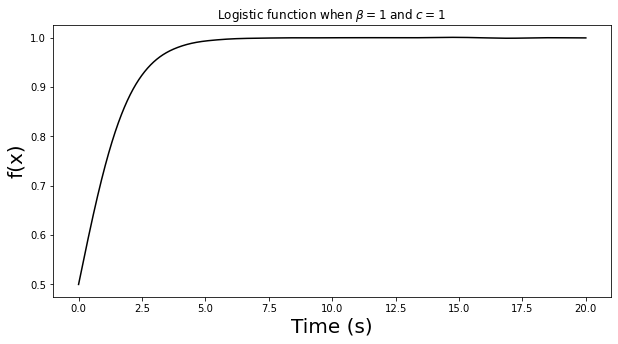

In [21]:
logistic_model = LogisticEquation(b=1, c=1)
ic = [0.5]  ## Initial condition
tpts, sol = logistic_model.solve(ic, 0, 20, 10000)


plt.figure(figsize=(10, 5))
plt.title(rf'Logistic function when $\beta = {logistic_model.b}$ and $ c = {logistic_model.c}$ ')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('f(x)', fontsize=20)
plt.plot(tpts, sol, color='k')
plt.savefig("figures/logistic_equation_function.jpg", figsize=(10, 5), bbox_inches='tight')


## Nonlinear Delay Differential Equation system

/Users/inhwankim/miniconda3/envs/cphy/lib/python3.9/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([g(tt[0])] + results)
/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/1541428779.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/ikeda_equation_function.jpg", figsize=(10, 5), bbox_inches='tight')


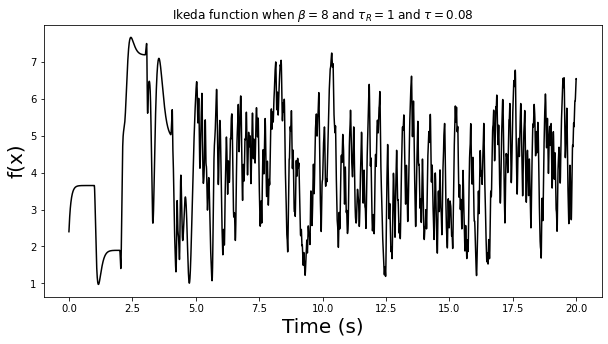

In [39]:
ic = 2.4 ## initial condition
delay = 1 ## delay time
beta = 8 ## intensity of nonlinear function
tau = 0.08  ## the system always has a response time

def values_before_zero(t):
    return ic

def model(y, t):
    return (beta/tau)*(np.sin(y(t - delay))**2) - y(t)/tau

def solve(t_min, t_max, nt):
    tpts = np.linspace(t_min, t_max, nt)
    sol = ddeint(model, values_before_zero, tpts)
    return tpts, sol

tpts, sol = solve(0, 20, 10000) ## time input

plt.figure(figsize=(10, 5))
plt.title(rf'Ikeda function when $\beta = {beta}$ and $\tau_R={delay}$ and $\tau={tau}$')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('f(x)', fontsize=20)
plt.plot(tpts, sol, color='k')
plt.savefig("figures/ikeda_equation_function.jpg", figsize=(10, 5), bbox_inches='tight')


----
# Spiderweb - zero response time case with large delays
### We can solve it using discontinuous solution

/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/246365102.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/cobweb_ikeda.jpg", figsize=(10, 5), bbox_inches='tight')


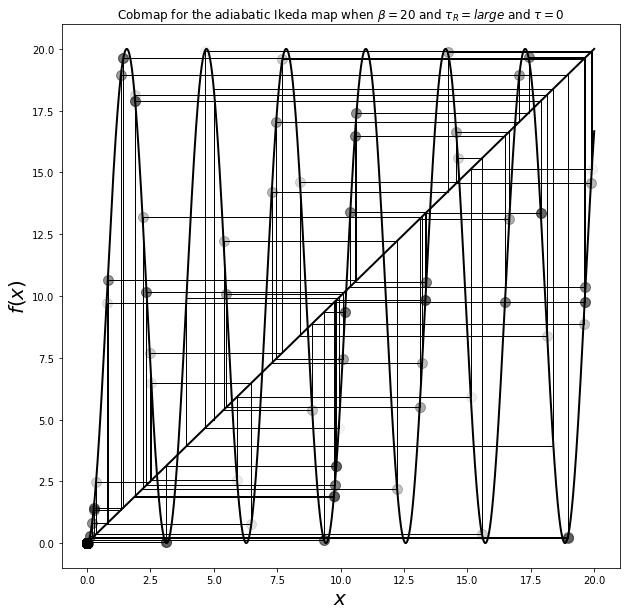

In [31]:
ikeda_adiabatic_model = spiderweb(n = 100)
ikeda_adiabatic_model.plot_adiabatic_ikeda(b = 20, ic = 5, t_min = 0, t_max = 20, tn = 10000)
plt.savefig("figures/cobweb_ikeda.jpg", figsize=(10, 5), bbox_inches='tight')


## Spiderweb - Logistic maps

/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/1304486658.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/cobweb_logistic1.jpg", figsize=(10, 5), bbox_inches='tight')


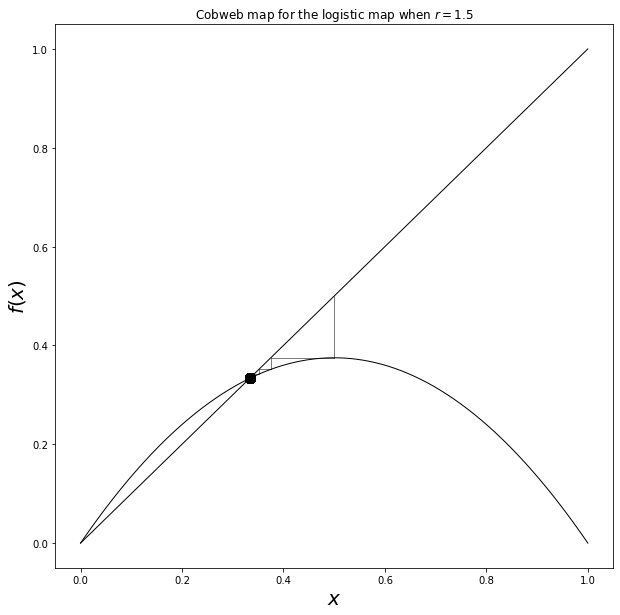

In [27]:
logistic_model = spiderweb(n = 1000)
logistic_model.plot_logistic(r = 1.5, ic = 0.5)
plt.savefig("figures/cobweb_logistic1.jpg", figsize=(10, 5), bbox_inches='tight')


/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/1016087187.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/cobweb_logistic2.jpg", figsize=(10, 5), bbox_inches='tight')


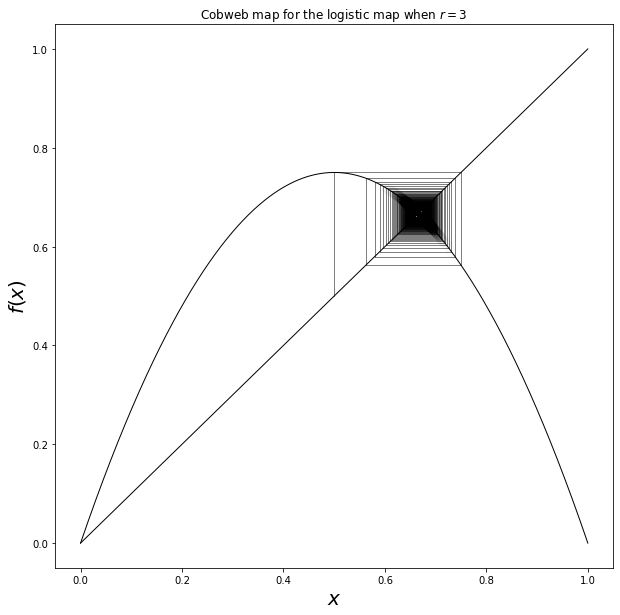

In [28]:
logistic_model = spiderweb(n = 1000)
logistic_model.plot_logistic(r = 3, ic = 0.5)
plt.savefig("figures/cobweb_logistic2.jpg", figsize=(10, 5), bbox_inches='tight')

/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/216566666.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/cobweb_logistic3.jpg", figsize=(10, 5), bbox_inches='tight')


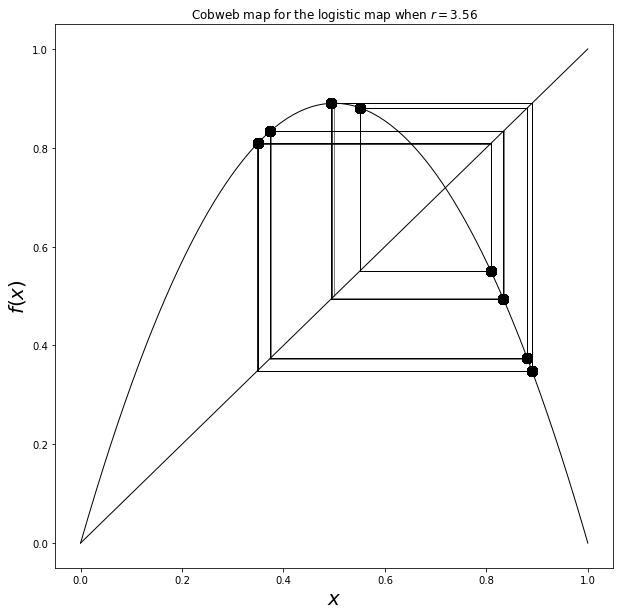

In [29]:
logistic_model = spiderweb(n = 1000)
logistic_model.plot_logistic(r = 3.56, ic = 0.5)
plt.savefig("figures/cobweb_logistic3.jpg", figsize=(10, 5), bbox_inches='tight')

/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/2453655479.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/cobweb_logistic4.jpg", figsize=(10, 5), bbox_inches='tight')


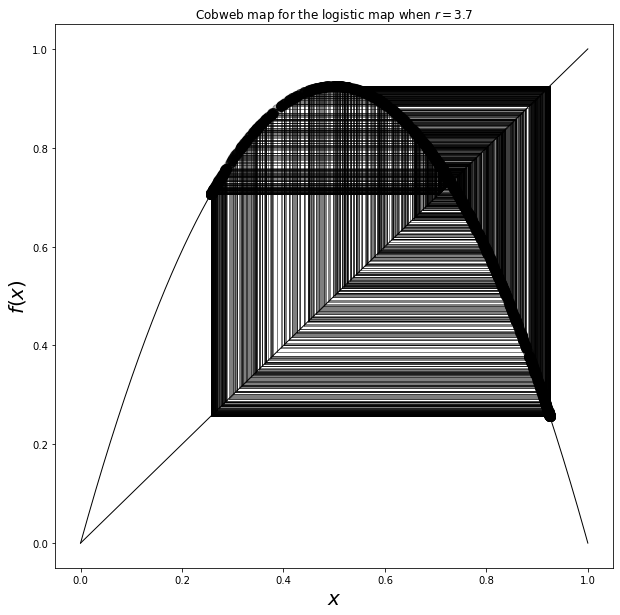

In [34]:
logistic_model = spiderweb(n = 1000)
logistic_model.plot_logistic(r = 3.7, ic = 0.5)
plt.savefig("figures/cobweb_logistic4.jpg", figsize=(10, 5), bbox_inches='tight')

## Bifurcation - Logistic maps

/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/2029073432.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/bi_logistic.jpg", figsize=(10, 5), bbox_inches='tight')


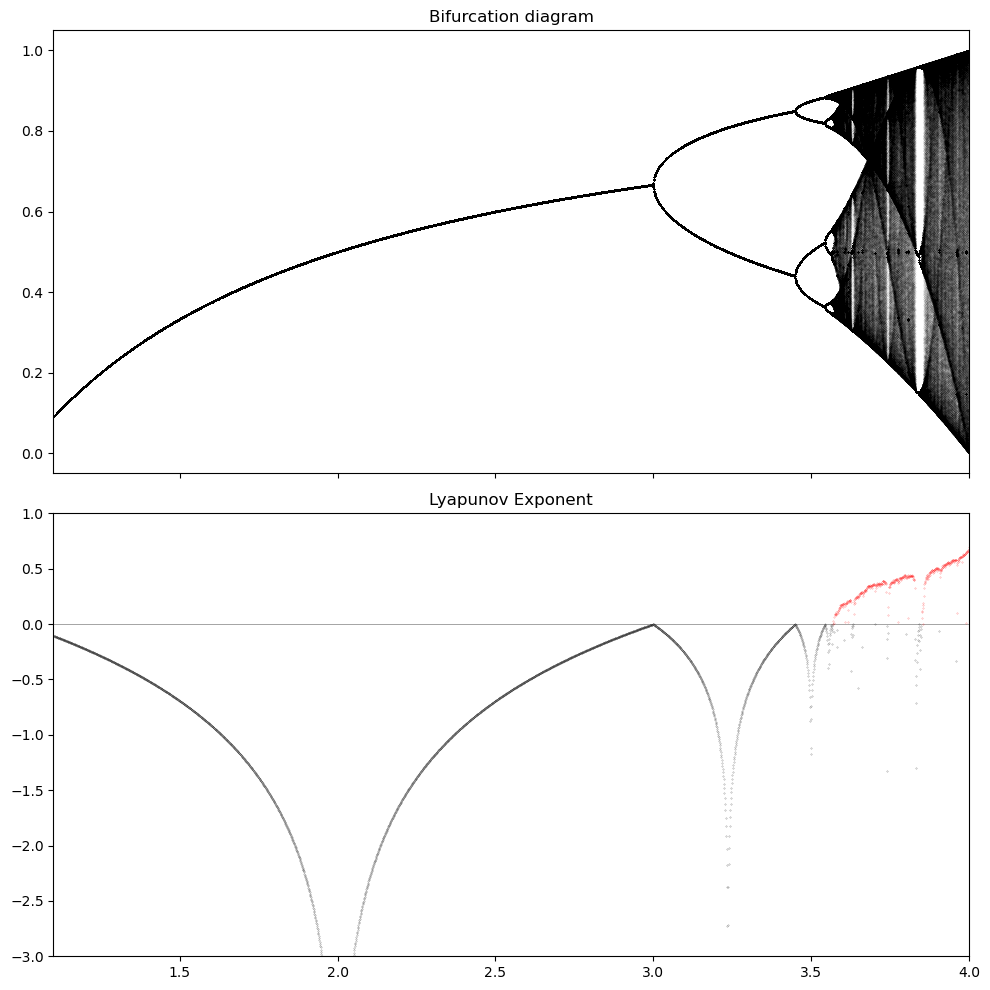

In [35]:
model = analysis(1.1, 4, 3000, 5000)
model.logistic_plot(1999, 0.6)
plt.savefig("figures/bi_logistic.jpg", figsize=(10, 5), bbox_inches='tight')

## Bifurcation - Ikeda maps

/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/3424403926.py:243: RuntimeWarning: divide by zero encountered in log
  lyap += np.log(abs(2*beta*np.sin(x)*np.cos(x)))
/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_51008/4172206587.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/bi_ikeda.jpg", figsize=(10, 5), bbox_inches='tight')


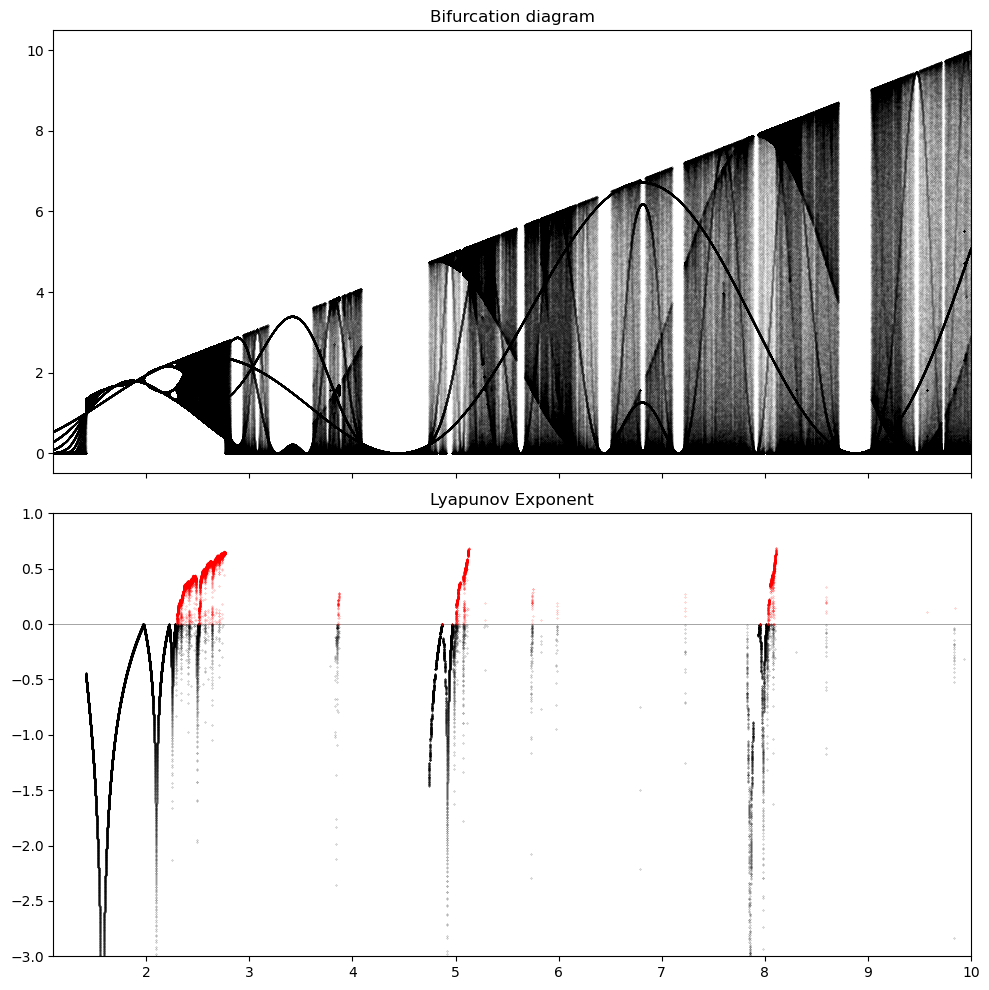

In [36]:
model = analysis(1.1, 10, 200000, 5000)
model.ikeda_adiabatic_plot(n_sol_show = 4999, ic = 1)
plt.savefig("figures/bi_ikeda.jpg", figsize=(10, 5), bbox_inches='tight')